## Import libraries


In [13]:
import pandas as pd

import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Data

In [14]:
# read files
unprocessed_df = pd.read_csv("../Data/US_videos.csv")
unprocessed_df.head()

# read json file
with open("../Data/US_category_id.json") as train_file:
    categories = json.load(train_file)["items"]

In [47]:
def get_category_id(categories):
    cat_dict = {}
    for cat in categories:
        cat_dict[int(cat["id"])] = cat["snippet"]["title"]
    return cat_dict

cat_dict = get_category_id(categories)
unprocessed_df['category_name'] = unprocessed_df['category_id'].map(cat_dict)
unprocessed_df.head(2)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",Entertainment


In [48]:
unprocessed_df.isnull().sum()
# Only desc has nulls 

video_id                    0
trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               570
category_name               0
dtype: int64

In [41]:
#df statistics
unprocessed_df.describe()

,category_id,views,likes,dislikes,comment_count
count,40949.000000,4.094900e+04,4.094900e+04,4.094900e+04,4.094900e+04
mean,19.972429,2.360785e+06,7.426670e+04,3.711401e+03,8.446804e+03
std,7.568327,7.394114e+06,2.288853e+05,2.902971e+04,3.743049e+04
min,1.000000,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,17.000000,2.423290e+05,5.424000e+03,2.020000e+02,6.140000e+02
50%,24.000000,6.818610e+05,1.809100e+04,6.310000e+02,1.856000e+03
75%,25.000000,1.823157e+06,5.541700e+04,1.938000e+03,5.755000e+03
max,43.000000,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06


We first need to define popularity levels. The levels can be defined using #comments. #views, #likes and #dislikes. 
Lets analyze the distribution of these variables. As the scale of the variables is really high the variables are transformed
on a log scale

In [15]:
unprocessed_df[['views_log', 'dislikes_log', 'likes_log']] = np.log(unprocessed_df[['views', 'dislikes', 'likes']] +1)

unprocessed_df.head(2)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,views_log,dislikes_log,likes_log
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,13.525659,7.995307,10.960027
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",14.698775,8.723719,11.484382


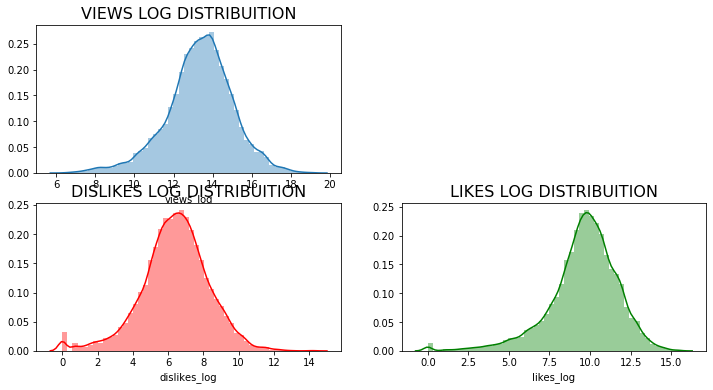

In [16]:
plt.figure(figsize = (12,6))
plt.subplot(221)
g1 = sns.distplot(unprocessed_df['views_log'])
g1.set_title("VIEWS LOG DISTRIBUITION", fontsize=16)

plt.subplot(224)
g2 = sns.distplot(unprocessed_df['likes_log'],color='green')
g2.set_title('LIKES LOG DISTRIBUITION', fontsize=16)

plt.subplot(223)
g3 = sns.distplot(unprocessed_df['dislikes_log'], color='r')
g3.set_title("DISLIKES LOG DISTRIBUITION", fontsize=16)

plt.show()



## Month wise distribution for published time

Text(0, 0.5, 'Count')

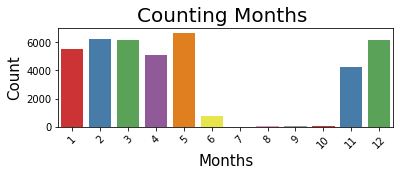

In [17]:
unprocessed_df['publish_time'] = pd.to_datetime(unprocessed_df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
unprocessed_df['published_month'] = unprocessed_df['publish_time'].dt.month
plt.subplot(211)
g = sns.countplot('published_month', data=unprocessed_df, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Counting Months ", fontsize=20)
g.set_xlabel("Months", fontsize=15)
g.set_ylabel("Count", fontsize=15)

Months from june till Nov has very less published videos. Maximum videos are published in the month of May.


## Month wise distribution for trending date

Text(0, 0.5, 'Count')

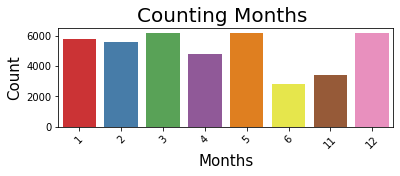

In [18]:
unprocessed_df['trending_date'] = pd.to_datetime(unprocessed_df['trending_date'], format='%y.%d.%m')
unprocessed_df['trending_month'] = unprocessed_df['trending_date'].dt.month

plt.subplot(211)
g = sns.countplot('trending_month', data=unprocessed_df, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Counting Months ", fontsize=20)
g.set_xlabel("Months", fontsize=15)
g.set_ylabel("Count", fontsize=15)

Months from june till Nov do not have trending data.

## Day wise distribution for published time

Text(0, 0.5, 'Count')

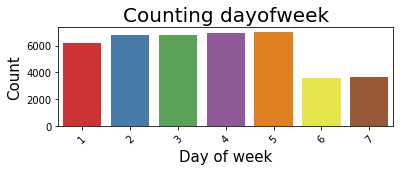

In [19]:
unprocessed_df['dayofweek'] = unprocessed_df['publish_time'].dt.dayofweek+1
plt.subplot(211)
g = sns.countplot('dayofweek', data=unprocessed_df, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Counting dayofweek", fontsize=20)
g.set_xlabel("Day of week", fontsize=15)
g.set_ylabel("Count", fontsize=15)

Surprisingly weekends (6 & 7) has less published videos that weekdays


## Day wise distribution for trending date

6    5993
2    5992
7    5794
5    5793
4    5793
1    5793
3    5791
Name: trending_day, dtype: int64


Text(0, 0.5, 'Count')

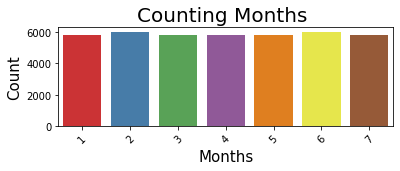

In [20]:
unprocessed_df['trending_day'] = unprocessed_df['trending_date'].dt.dayofweek+1

print(unprocessed_df['trending_day'].value_counts())
plt.subplot(211)
g = sns.countplot('trending_day', data=unprocessed_df, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Counting Months ", fontsize=20)
g.set_xlabel("Months", fontsize=15)
g.set_ylabel("Count", fontsize=15)

All weeks have more or less same trending counts in the data

In [21]:
# separates date and time into two columns from 'publish_time' column
unprocessed_df['time'] = unprocessed_df['publish_time'].dt.time

unprocessed_df[['hour','min','sec']] = unprocessed_df['time'].astype(str).str.split(':', expand=True).astype(int)

unprocessed_df['hour'][:5]

0    17
1     7
2    19
3    11
4    18
Name: hour, dtype: int64

Text(0, 0.5, 'Count')

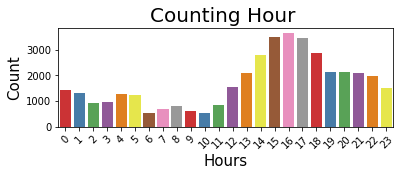

In [29]:
plt.subplot(211)
g = sns.countplot('hour', data=unprocessed_df, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Counting Hour ", fontsize=20)
g.set_xlabel("Hours", fontsize=15)
g.set_ylabel("Count", fontsize=15)

Maximum videos are published during 15,16,17 hours. 